In [470]:
import sys
import time

sys.path.append('/home/cstephenson/Magnolia/sandbox/BLSTM-DC/')
sys.path.append('/home/cstephenson/Magnolia/src/utils')

import numpy as np

from deep_clustering_model import DeepClusteringModel
from clustering_utils import clustering_separate, get_cluster_masks

from magnolia.features.mixer import FeatureMixer
from magnolia.features.spectral_features import istft
from magnolia.features.data_preprocessing import undo_preemphasis
from magnolia.utils.bss_eval import bss_eval_sources

import IPython
from IPython.display import Audio
from matplotlib import pyplot as plt
fig_size = [0,0]
fig_size[0] = 8
fig_size[1] = 4
plt.rcParams["figure.figsize"] = fig_size

### Hyperparameters used

In [479]:
# Size of BLSTM layers
layer_size = 600

# Size of embedding vectors
K = 40

# Size of training batches T = #windows F = #Frequency bins
T = 40
F = 257

# Training parameters
batch_size = 512

# STFT parameters used
sample_rate = 10e3
window_size = 0.0512
overlap = 0.0256
fft_size = 512

### Create feature mixes for both the training and validation data

In [4]:
train_data = '/home/cstephenson/Data/librispeech/processed_train-clean-100.h5'
validation_data = '/home/cstephenson/Data/librispeech/processed_dev_clean.h5'

train_mixer = FeatureMixer([train_data,train_data], shape=(T,None))
validation_mixer = FeatureMixer([validation_data,validation_data], shape=(T,None))

### Functions for creating training batches and dealing with spectrograms

In [5]:
def scale_spectrogram(spectrogram):
    mag_spec = np.abs(spectrogram)
    phases = np.unwrap(np.angle(spectrogram))
    
    mag_spec = np.sqrt(mag_spec)
    M = mag_spec.max()
    m = mag_spec.min()
    
    return (mag_spec - m)/(M - m), phases
    

def gen_batch(mixer,batch_size):
    X = np.zeros((batch_size,T,F))
    phases = np.zeros((batch_size,T,F))
    y = np.zeros((batch_size,T,F,2))
    
    for i in range(batch_size):
        data = next(mixer)
        
        X[i], _ = scale_spectrogram(data[0])
        phases[i] = np.unwrap(np.angle(data[0]))
        y[i,:,:,0] = 1/2*(np.sign(np.abs(data[1]) - np.abs(data[2])) + 1)
        y[i,:,:,1] = 1 - y[i,:,:,0]
    return X, y, phases

def invert_spectrogram(magnitude,phase):
    return istft(np.square(magnitude)*np.exp(phase*1.0j),sample_rate,None,overlap,two_sided=False,fft_size=fft_size)

### Generate a sample from the validation data

In [6]:
X_vala, y_vala, phases = gen_batch(validation_mixer,10*batch_size)

### Load an instance of the deep clustering model

In [480]:
model = DeepClusteringModel()
model.load('models/magnolia/deep_clustering.ckpt')

iterations = []
costs = []

t_costs = []
v_costs = []

### Train the model on batches from the training dataset

Plot the error on the training set and the validation sample every so often

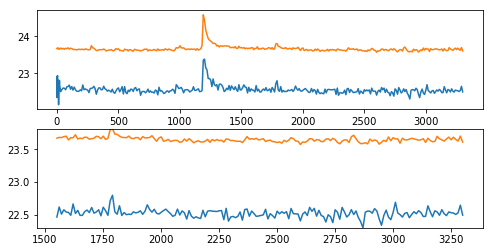

Cost is 23.6082


KeyboardInterrupt: 

In [ ]:
try:
    start = iterations[-1]
except:
    start = 0

for i in range(200000):
    X_train, y_train, phases = gen_batch(train_mixer,batch_size)
    c = model.train_on_batch(X_train, y_train)
    costs.append(c)
    
    if (i+1) % 10 == 0:
        IPython.display.clear_output(wait=True)
        c_v = model.get_cost(X_vala, y_vala)
        
        if len(iterations):
            if c_v < min(v_costs) and iterations[-1] > 0:
                print("Saving the model because c_v is", c_v)
                model.save('models/magnolia/deep_clustering.ckpt')
            
        t_costs.append(np.mean(costs))
        v_costs.append(c_v)
        iterations.append(i + start)
        
        length = len(iterations)
        cutoff = int(0.5*length)
        
        f, (ax1, ax2) = plt.subplots(2,1)
        
        ax1.plot(iterations,t_costs)
        ax1.plot(iterations,v_costs)
        
        y_u = max(max(t_costs[cutoff:]),max(v_costs[cutoff:]))
        y_l = min(min(t_costs[cutoff:]),min(v_costs[cutoff:]))
        ax2.set_ylim(y_l,y_u)
        
        ax2.plot(iterations[cutoff:], t_costs[cutoff:])
        ax2.plot(iterations[cutoff:], v_costs[cutoff:])
        plt.show()
        print("Cost is", c_v)
        costs = []

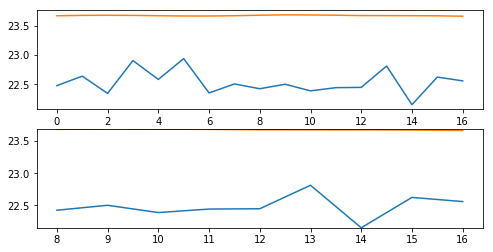

In [483]:
length = len(iterations)
cutoff = int(0.5*length)

f, (ax1, ax2) = plt.subplots(2,1)

ax1.plot(iterations,t_costs)
ax1.plot(iterations,v_costs)

y_u = max(max(t_costs[cutoff:]),max(v_costs[cutoff:]))
y_l = min(min(t_costs[cutoff:]),min(v_costs[cutoff:]))
ax2.set_ylim(y_l,y_u)

ax2.plot(iterations[cutoff:], t_costs[cutoff:])
ax2.plot(iterations[cutoff:], v_costs[cutoff:])
plt.show()

### Listen to an example separation from the validation data

In [484]:
long_mixer = FeatureMixer([validation_data,validation_data], shape=(5*T,None)) 

In [525]:
data = next(long_mixer)
spec = data[0]
signal = istft(spec,sample_rate,None,overlap,two_sided=False,fft_size=512)
signal = undo_preemphasis(signal)

Audio(signal,rate=sample_rate)

In [526]:
sources = clustering_separate(signal,sample_rate,model,2)

In [527]:
Audio(sources[0], rate=sample_rate)

In [528]:
Audio(sources[1], rate=sample_rate)

### Visualize the the learned affinity matrix

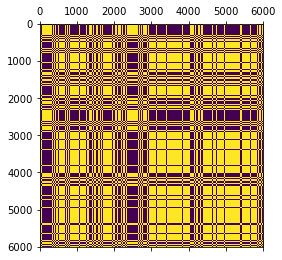

In [548]:
X_ex, y_ex, phases = gen_batch(validation_mixer,1)
vectors = model.get_vectors(X_ex)

res = vectors[0].reshape((T*F,K))
resa = y_ex[0].reshape((T*F,2))

A = resa @ resa.T
B = (res @ res.T)

plt.matshow(A[0:6000,0:6000])
plt.show()

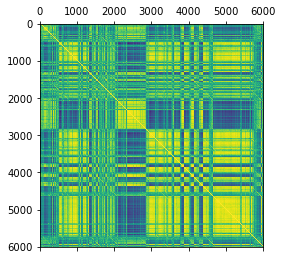

In [549]:
plt.matshow(B[0:6000,0:6000])
plt.show()

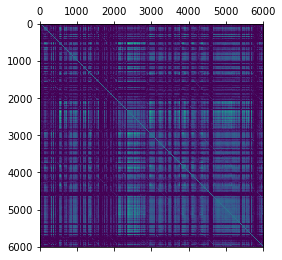

In [550]:
plt.matshow(np.square(B[0:6000,0:6000] - 1/2))
plt.show()

### Evaluate BSS metrics on the test data

In [310]:
test_data = '/home/cstephenson/Data/librispeech/processed_test_clean.h5'
test_mixer = FeatureMixer([test_data,test_data], shape=(T,None))

In [311]:
X_test, y_test, _ = gen_batch(test_mixer, batch_size)

In [312]:
def bss_eval_batch(mixer, num_sources):
    data = next(mixer)
    
    mixes = [invert_spectrogram(np.abs(data[0]),np.unwrap(np.angle(data[0]))) for i in range(1,num_sources + 1)]
    sources = [invert_spectrogram(np.abs(data[i]),np.unwrap(np.angle(data[i]))) for i in range(1,num_sources + 1)]
    
    mixes = [undo_preemphasis(mix) for mix in mixes]
    sources = [undo_preemphasis(source) for source in sources]
    
    input_mix = np.stack(mixes)
    reference_sources = np.stack(sources)
    estimated_sources = clustering_separate(mixes[0],1e4,model,num_sources)
    
    do_nothing = bss_eval_sources(reference_sources, input_mix)
    do_something = bss_eval_sources(reference_sources, estimated_sources)
    
    sdr = do_something[0] - do_nothing[0]
    sir = do_something[1] - do_nothing[1]
    sar = do_something[2] - do_nothing[2]
    
    return {'SDR': sdr, 'SIR': sir, 'SAR': sar}